In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from scipy.stats import norm
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

In [2]:
df = pd.read_csv('framingham.csv')
df = df.fillna(df.median())

print('Has Heart Disease:', np.sum(df['TenYearCHD'])/len(df['TenYearCHD']))
print('Does Not Have Heart Disease:', 1 - (np.sum(df['TenYearCHD'])/len(df['TenYearCHD'])))

Has Heart Disease: 0.15188679245283018
Does Not Have Heart Disease: 0.8481132075471698


Multiple Logistic Regression Model

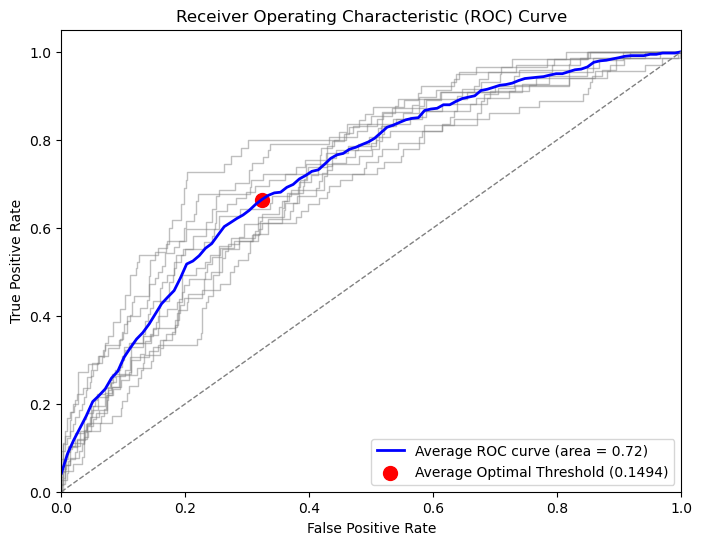

Average AUC: 0.7246902784980708

Average Accuracy: 0.8554245283018866

Average Classification Report:
   precision    recall  f1-score  support
0   0.857898  0.994133  0.920974    359.6
1   0.745476  0.079428  0.141277     64.4

Average Feature Coefficients:
                 Coefficient  Odds Ratio
Feature                                 
prevalentStroke     0.784980    2.214637
age                 0.532855    1.703868
male                0.497635    1.646559
sysBP               0.309585    1.362993
cigsPerDay          0.254785    1.290622
BPMeds              0.238113    1.271746
prevalentHyp        0.231344    1.261107
diabetes            0.181780    1.204168
glucose             0.154134    1.166741
totChol             0.080604    1.084215
BMI                 0.013156    1.013398
currentSmoker       0.012336    1.013449
education          -0.014101    0.986130
heartRate          -0.018801    0.981511
diaBP              -0.032015    0.968711


In [3]:
# Load the dataset
df = pd.read_csv('framingham.csv')
df = df.fillna(df.median())

# Define features and target
y = df['TenYearCHD']
X = df.drop('TenYearCHD', axis=1)

# Define feature types
continuous_features = [
    'glucose', 'heartRate', 'BMI', 'diaBP', 'sysBP', 'totChol', 'cigsPerDay', 'age'
]

binary_categorical_features = [
    'male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes'
]

ordinal_categorical_features = ['education']

# Define preprocessor
continuous_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_features),
        ('bin_cat', 'passthrough', binary_categorical_features),
        ('ord_cat', 'passthrough', ordinal_categorical_features)
    ])

# Initialize KFold cross-validator
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store performance metrics across folds
fprs = []
tprs = []
aucs = []
optimal_thresholds = []
classification_reports = []
accuracy_df = pd.DataFrame(columns=['Fold', 'Accuracy'])  # DataFrame to store accuracy for each fold
feature_coefficients_df = pd.DataFrame()  # DataFrame to store feature coefficients for each fold

# Iterate over folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Define logistic regression model pipeline for this fold
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    fprs.append(fpr)
    tprs.append(tpr)
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Find the index of the threshold closest to the model's threshold
    idx = np.argmax(tpr - fpr)
    optimal_thresholds.append(thresholds[idx])
    
    # Print classification report on the test set
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(pd.DataFrame(report).transpose())
    
    # Store accuracy for this fold
    accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'Fold': [i + 1], 'Accuracy': [report['accuracy']]})], ignore_index=True)

    # Get feature coefficients and odds ratios
    feature_names = np.hstack([
        continuous_features,
        binary_categorical_features,
        ordinal_categorical_features
    ])
    coefficients = model.named_steps['classifier'].coef_[0]
    feature_coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    feature_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)
    feature_coefficients['Odds Ratio'] = np.exp(feature_coefficients['Coefficient'])
    feature_coefficients_df = pd.concat([feature_coefficients_df, feature_coefficients])
    average_feature_coefficients_df = feature_coefficients_df.groupby('Feature').mean()
    average_feature_coefficients_df = average_feature_coefficients_df.sort_values(by='Coefficient', ascending=False)

# Plot ROC curves for each fold
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.plot(fprs[i], tprs[i], color='gray', lw=1, alpha=0.5)

# Interpolate ROC curves to have the same number of points
mean_fpr = np.linspace(0, 1, 100)
tprs_interp = []
for i in range(k):
    tprs_interp.append(np.interp(mean_fpr, fprs[i], tprs[i]))
mean_tpr = np.mean(tprs_interp, axis=0)

# Plot average ROC curve
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Average ROC curve (area = {mean_auc:.2f})')

# Plot optimal thresholds
mean_optimal_threshold = np.mean(optimal_thresholds)
plt.scatter(mean_fpr[np.argmax(mean_tpr - mean_fpr)], mean_tpr[np.argmax(mean_tpr - mean_fpr)], color='red', s=100, label=f'Average Optimal Threshold ({mean_optimal_threshold:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate average AUC
average_auc = np.mean(aucs)
print("Average AUC:", average_auc)
print('')

# Print average accuracy for all folds
average_accuracy = accuracy_df['Accuracy'].mean()
print("Average Accuracy:", average_accuracy)
print('')

# Print average classification report
print("Average Classification Report:")
average_report = pd.concat(classification_reports).groupby(level=0).mean()
# Drop unwanted rows
average_report = average_report.drop(['accuracy', 'macro avg', 'weighted avg'])
print(average_report)
print('')

print("Average Feature Coefficients:")
print(average_feature_coefficients_df)

Random Forest Classifier Model

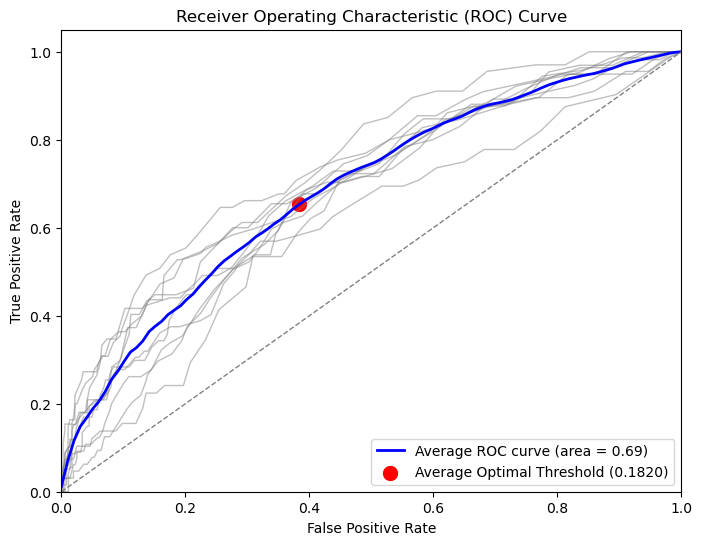

Average AUC: 0.6864790349170768

Average Accuracy: 0.8490566037735849

Average Classification Report:
   precision    recall  f1-score  support
0   0.854605  0.990544  0.917516    359.6
1   0.535317  0.059076  0.105604     64.4

Average Feature Importances:
                 Importance
Feature                    
cigsPerDay         0.135323
education          0.127887
BPMeds             0.123330
prevalentHyp       0.121750
male               0.118150
currentSmoker      0.116797
age                0.097292
prevalentStroke    0.051577
glucose            0.038639
diabetes           0.020507
BMI                0.018343
totChol            0.012396
heartRate          0.007180
sysBP              0.006965
diaBP              0.003862


In [4]:
# Load the dataset
df = pd.read_csv('framingham.csv')
df = df.fillna(df.median())

# Define features and target
y = df['TenYearCHD']
X = df.drop('TenYearCHD', axis=1)

# Define feature types
continuous_features = [
    'glucose', 'heartRate', 'BMI', 'diaBP', 'sysBP', 'totChol', 'cigsPerDay', 'age'
]

binary_categorical_features = [
    'male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes'
]

ordinal_categorical_features = ['education']

# Define preprocessor
continuous_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_features),
        ('bin_cat', 'passthrough', binary_categorical_features),
        ('ord_cat', 'passthrough', ordinal_categorical_features)
    ])

# Initialize KFold cross-validator
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store performance metrics across folds
fprs = []
tprs = []
aucs = []
optimal_thresholds = []
classification_reports = []
accuracy_df = pd.DataFrame(columns=['Fold', 'Accuracy'])  # DataFrame to store accuracy for each fold
feature_importances_df = pd.DataFrame()  # DataFrame to store feature importances for each fold

# Iterate over folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Define Random Forest model pipeline for this fold
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    fprs.append(fpr)
    tprs.append(tpr)
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Find the index of the threshold closest to the model's threshold
    idx = np.argmax(tpr - fpr)
    optimal_thresholds.append(thresholds[idx])
    
    # Print classification report on the test set
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(pd.DataFrame(report).transpose())
    
    # Store accuracy for this fold
    accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'Fold': [i + 1], 'Accuracy': [report['accuracy']]})], ignore_index=True)

    # Get feature importances
    importances = model.named_steps['classifier'].feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    })
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    feature_importances_df = pd.concat([feature_importances_df, feature_importances])
    average_feature_importances_df = feature_importances_df.groupby('Feature').mean()
    average_feature_importances_df = average_feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot ROC curves for each fold
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.plot(fprs[i], tprs[i], color='gray', lw=1, alpha=0.5)

# Interpolate ROC curves to have the same number of points
mean_fpr = np.linspace(0, 1, 100)
tprs_interp = []
for i in range(k):
    tprs_interp.append(np.interp(mean_fpr, fprs[i], tprs[i]))
mean_tpr = np.mean(tprs_interp, axis=0)

# Plot average ROC curve
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Average ROC curve (area = {mean_auc:.2f})')

# Plot optimal thresholds
mean_optimal_threshold = np.mean(optimal_thresholds)
plt.scatter(mean_fpr[np.argmax(mean_tpr - mean_fpr)], mean_tpr[np.argmax(mean_tpr - mean_fpr)], color='red', s=100, label=f'Average Optimal Threshold ({mean_optimal_threshold:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate average AUC
average_auc = np.mean(aucs)
print("Average AUC:", average_auc)
print('')

# Print average accuracy for all folds
average_accuracy = accuracy_df['Accuracy'].mean()
print("Average Accuracy:", average_accuracy)
print('')

# Print average classification report
print("Average Classification Report:")
average_report = pd.concat(classification_reports).groupby(level=0).mean()
# Drop unwanted rows
average_report = average_report.drop(['accuracy', 'macro avg', 'weighted avg'])
print(average_report)
print('')

print("Average Feature Importances:")
print(average_feature_importances_df)

XGBoost Classifier Model

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Best parameters found:
{'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__min_child_weight': 10, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 1.0, 'classifier__subsample': 0.8}

Best ROC AUC score found: 0.7148274960472621



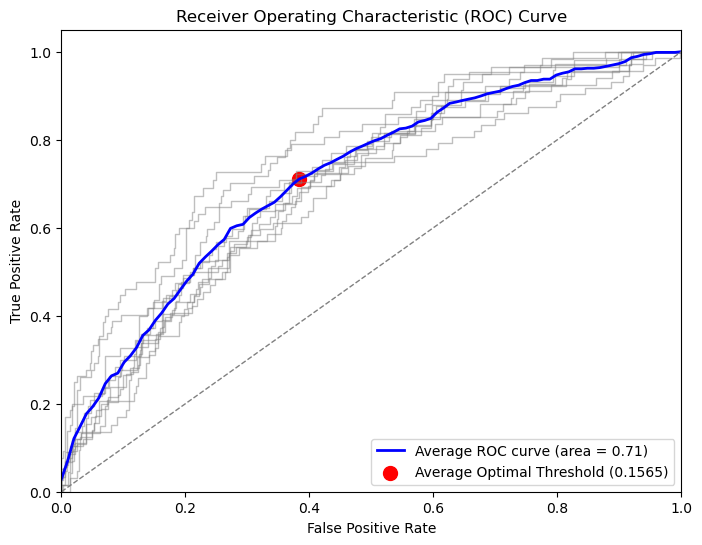

Average AUC: 0.7148274960472621

Average Accuracy: 0.8502358490566037

Average Classification Report:
   precision    recall  f1-score  support
0   0.853736  0.993567  0.918324    359.6
1   0.575714  0.049574  0.090710     64.4

Average Feature Importances:
                 Importance
Feature                    
prevalentHyp       0.165470
BMI                0.150994
cigsPerDay         0.111657
diabetes           0.090485
male               0.073287
prevalentStroke    0.064214
currentSmoker      0.054109
sysBP              0.052292
totChol            0.051940
BPMeds             0.049324
glucose            0.048125
education          0.042843
age                0.039714
heartRate          0.005544
diaBP              0.000000


In [5]:
# Load the dataset
df = pd.read_csv('framingham.csv')
df = df.fillna(df.median())

# Define features and target
y = df['TenYearCHD']
X = df.drop('TenYearCHD', axis=1)

# Define feature types
continuous_features = [
    'glucose', 'heartRate', 'BMI', 'diaBP', 'sysBP', 'totChol', 'cigsPerDay', 'age'
]

binary_categorical_features = [
    'male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes'
]

ordinal_categorical_features = ['education']

# Define preprocessor
continuous_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_features),
        ('bin_cat', 'passthrough', binary_categorical_features),
        ('ord_cat', 'passthrough', ordinal_categorical_features)
    ])

# Define XGBoost classifier
classifier = XGBClassifier()

# Define hyperparameters grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100],  # Default: 100
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5, 6], 
    'classifier__min_child_weight': [1, 5, 10], 
    'classifier__subsample': [0.8, 0.9, 1.0],  
    'classifier__colsample_bytree': [0.8, 0.9, 1.0], 
    'classifier__gamma': [0],  # Default: 0
    'classifier__reg_alpha': [0],  # Default: 0
    'classifier__reg_lambda': [1.0],  # Default: 1.0
}
# Initialize KFold cross-validator
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)]),
    param_grid=param_grid,
    cv=kf,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Get the best estimator from GridSearchCV
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)
print('')

# Print the best score found
print("Best ROC AUC score found:", grid_search.best_score_)
print('')

# Define the best XGBoost model using the best hyperparameters
best_xgb_model = grid_search.best_estimator_

# Lists to store performance metrics across folds
fprs = []
tprs = []
aucs = []
optimal_thresholds = []
classification_reports = []
accuracy_df = pd.DataFrame(columns=['Fold', 'Accuracy'])  # DataFrame to store accuracy for each fold
feature_importances_df = pd.DataFrame()  # DataFrame to store feature importances for each fold

# Iterate over folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the best XGBoost model
    best_xgb_model.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_scores = best_xgb_model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    fprs.append(fpr)
    tprs.append(tpr)
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Find the index of the threshold closest to the model's threshold
    idx = np.argmax(tpr - fpr)
    optimal_thresholds.append(thresholds[idx])
    
    # Print classification report on the test set
    y_pred = best_xgb_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(pd.DataFrame(report).transpose())
    
    # Store accuracy for this fold
    accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'Fold': [i + 1], 'Accuracy': [report['accuracy']]})], ignore_index=True)

    # Get feature importances
    importances = best_xgb_model.named_steps['classifier'].feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    })
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    feature_importances_df = pd.concat([feature_importances_df, feature_importances])
    average_feature_importances_df = feature_importances_df.groupby('Feature').mean()
    average_feature_importances_df = average_feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot ROC curves for each fold
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.plot(fprs[i], tprs[i], color='gray', lw=1, alpha=0.5)

# Interpolate ROC curves to have the same number of points
mean_fpr = np.linspace(0, 1, 100)
tprs_interp = []
for i in range(k):
    tprs_interp.append(np.interp(mean_fpr, fprs[i], tprs[i]))
mean_tpr = np.mean(tprs_interp, axis=0)

# Plot average ROC curve
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Average ROC curve (area = {mean_auc:.2f})')

# Plot optimal thresholds
mean_optimal_threshold = np.mean(optimal_thresholds)
plt.scatter(mean_fpr[np.argmax(mean_tpr - mean_fpr)], mean_tpr[np.argmax(mean_tpr - mean_fpr)], color='red', s=100, label=f'Average Optimal Threshold ({mean_optimal_threshold:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate average AUC
average_auc = np.mean(aucs)
print("Average AUC:", average_auc)
print('')

# Print average accuracy for all folds
average_accuracy = accuracy_df['Accuracy'].mean()
print("Average Accuracy:", average_accuracy)
print('')

# Print average classification report
print("Average Classification Report:")
average_report = pd.concat(classification_reports).groupby(level=0).mean()
# Drop unwanted rows
average_report = average_report.drop(['accuracy', 'macro avg', 'weighted avg'])
print(average_report)
print('')

print("Average Feature Importances:")
print(average_feature_importances_df)

Investigating Most Relevant Features

Optimization terminated successfully.
         Current function value: 0.424316
         Iterations 6


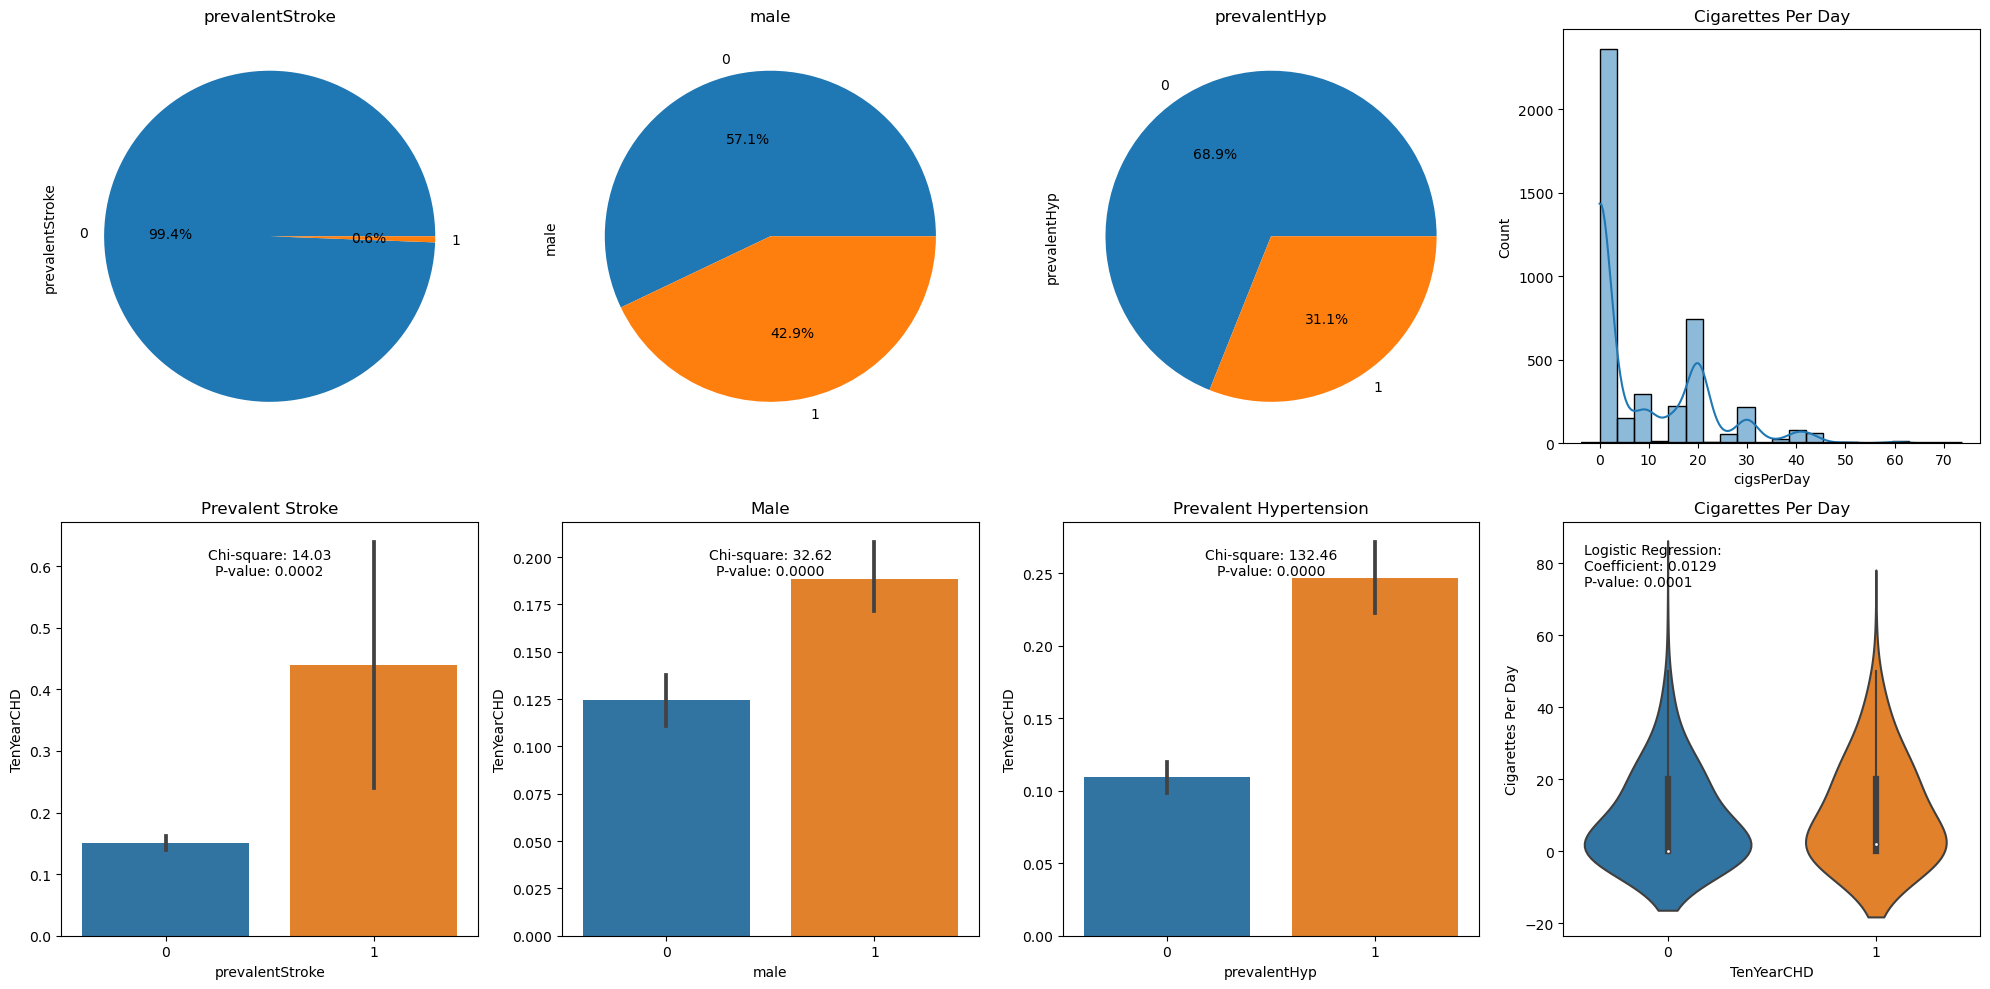

In [8]:
# All of the models performed similarly. The most common important features across the models:
# prevalentStroke, cigsPerDay, male, prevalentHyp

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Plot pie charts for the first three categorical variables on the top row
categorical_variables = ["prevalentStroke", "male", "prevalentHyp"]
for i, var in enumerate(categorical_variables):
    df[var].value_counts().plot.pie(autopct='%1.1f%%', ax=axs[0, i])
    axs[0, i].set_title(var)

# Plot histogram for cigsPerDay with a fitted probability distribution on the top row
sns.histplot(data=df, x='cigsPerDay', ax=axs[0, 3], bins=20, kde=True)
# Fit a normal distribution to the data
mu, std = norm.fit(df['cigsPerDay'].dropna())
xmin, xmax = axs[0, 3].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[0, 3].plot(x, p, 'k', linewidth=2)
axs[0, 3].set_title('Cigarettes Per Day')

# Plot graphs for the bottom row
# Plot for prevalentStroke
sns.barplot(x='prevalentStroke', y='TenYearCHD', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Prevalent Stroke')

# Plot for male
sns.barplot(x='male', y='TenYearCHD', data=df, ax=axs[1, 1])
axs[1, 1].set_title('Male')

# Plot for prevalentHyp
sns.barplot(x='prevalentHyp', y='TenYearCHD', data=df, ax=axs[1, 2])
axs[1, 2].set_title('Prevalent Hypertension')

# Plot for cigsPerDay with box plot
sns.violinplot(x='TenYearCHD', y='cigsPerDay', data=df, ax=axs[1, 3], bw=0.7)
axs[1, 3].set_xlabel('TenYearCHD')
axs[1, 3].set_ylabel('Cigarettes Per Day')
axs[1, 3].set_title('Cigarettes Per Day')

# Define the variables for the chi-square test
variables = ["prevalentStroke", "male", "prevalentHyp"]

# Iterate over the variables
for i, var in enumerate(variables):
    # Create the contingency table
    contingency_table = pd.crosstab(df[var], df['TenYearCHD'])
    
    # Perform the chi-square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Print the Chi-square statistic and p-value on the plot
    axs[1, i].text(0.5, 0.9, f"Chi-square: {chi2:.2f}\nP-value: {p:.4f}", 
                   horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, i].transAxes, fontsize=10)

# Fit logistic regression model
X = df[['cigsPerDay']]
X = sm.add_constant(X)
y = df['TenYearCHD']
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print the logistic regression coefficient and p-value on the plot
axs[1, 3].text(0.05, 0.95, f"Logistic Regression:\nCoefficient: {result.params['cigsPerDay']:.4f}\nP-value: {result.pvalues['cigsPerDay']:.4f}", 
               horizontalalignment='left', verticalalignment='top', 
               transform=axs[1, 3].transAxes, fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()